In [ ]:
!pip install prophet

In [ ]:
import pandas as pd

# Load dataset safely
file_path = "/content/cinemaTicket_Ref.csv"
try:
    df = pd.read_csv(file_path, delimiter=",", on_bad_lines='skip')
except Exception as e:
    print(f"Error reading CSV: {e}")
    exit()

# Convert 'date' column if it exists
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
else:
    print("Error: 'date' column not found in the dataset!")
    exit()

# Handle missing values
if df.isnull().values.any():
    df.fillna(df.median(numeric_only=True), inplace=True)

# Ensure necessary columns exist before aggregation
required_cols = {'total_sales', 'tickets_sold', 'occu_perc'}
if required_cols.issubset(df.columns):
    df_daily = df.groupby('date').agg({
        'total_sales': 'sum',
        'tickets_sold': 'sum',
        'occu_perc': 'mean'
    }).reset_index()

    # Save cleaned dataset (avoid overwriting original)
    output_file = "/content/cinemaTicket_Ref_cleaned.csv"
    df_daily.to_csv(output_file, index=False)
    print(f"Data Preprocessing Complete! Saved to {output_file}")
else:
    missing_cols = required_cols - set(df.columns)
    print(f"Error: Missing columns in dataset - {missing_cols}")


Data Preprocessing Complete! Saved to /content/cinemaTicket_Ref_cleaned.csv


In [ ]:
import pandas as pd

# Convert date column safely
df['date'] = pd.to_datetime(df["date"], errors='coerce')

# Check available columns
print("Available columns:", df.columns)

# Normalize column names (fix case sensitivity & whitespace)
df.columns = df.columns.str.lower().str.strip()

# Ensure required columns exist
required_cols = {'film_code', 'cinema_code'}
if required_cols.issubset(df.columns):
    n_unique_film = df['film_code'].nunique()
    n_unique_cinema = df['cinema_code'].nunique()
    print(f"Number of unique films = {n_unique_film}")
    print(f"Number of unique cinemas = {n_unique_cinema}")
else:
    missing_cols = required_cols - set(df.columns)
    print(f"Error: Missing columns in dataset - {missing_cols}")
    exit()

# Display dataset shape
print(f"Dataset shape: {df.shape}")

# Check for duplicate rows
number_duplicates = df.duplicated().sum()
print(f"STATUS: Total duplicated rows = {number_duplicates}")

# Show first few rows
df.head()


Available columns: Index(['film_code', 'cinema_code', 'total_sales', 'tickets_sold',
       'tickets_out', 'show_time', 'occu_perc', 'ticket_price', 'ticket_use',
       'capacity', 'date', 'month', 'quarter', 'day'],
      dtype='object')
Number of unique films = 48
Number of unique cinemas = 246
Dataset shape: (142524, 14)
STATUS: Total duplicated rows = 106


,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


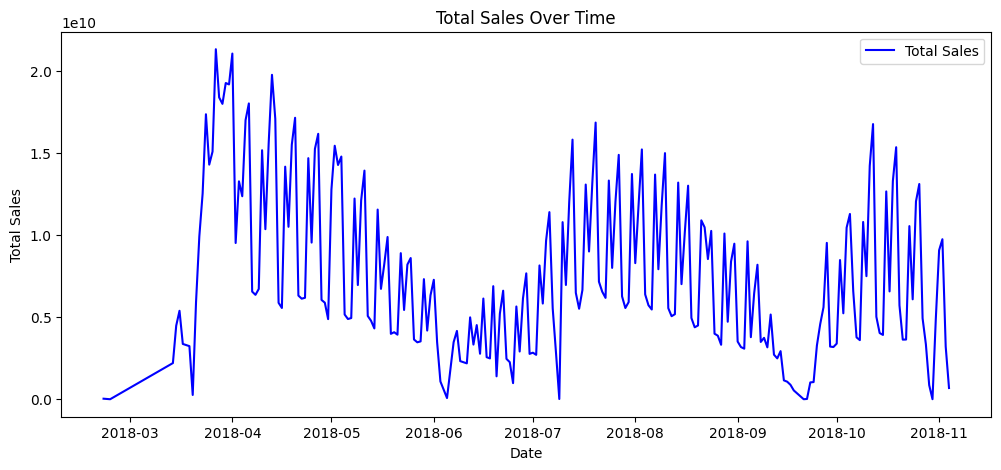

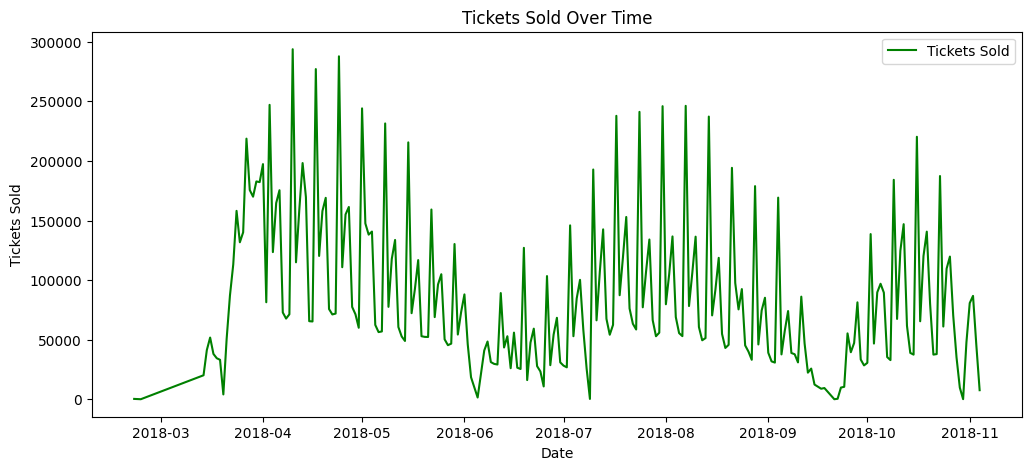

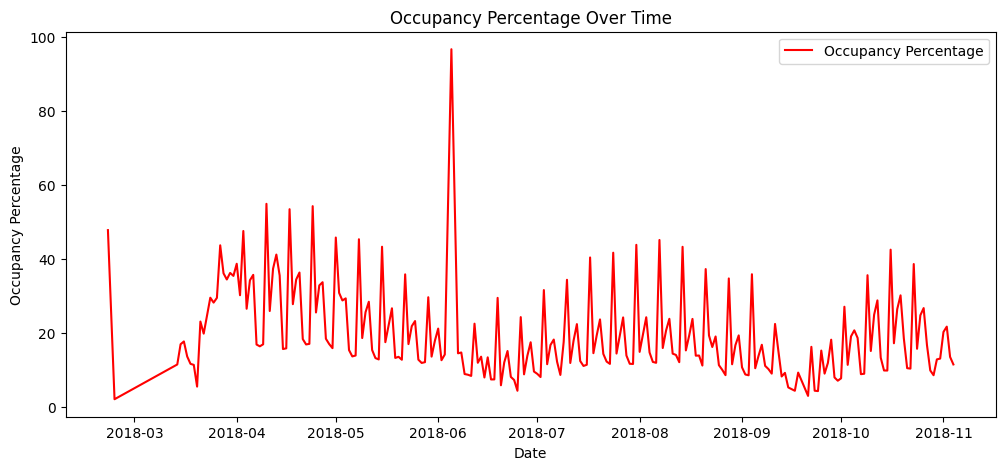

In [ ]:
import matplotlib.pyplot as plt

# Plot Total Sales Over Time
plt.figure(figsize=(12, 5))
plt.plot(df_daily['date'], df_daily['total_sales'], label="Total Sales", color="blue")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Over Time")
plt.legend()
plt.show()

# Plot Tickets Sold Over Time
plt.figure(figsize=(12, 5))
plt.plot(df_daily['date'], df_daily['tickets_sold'], label="Tickets Sold", color="green")
plt.xlabel("Date")
plt.ylabel("Tickets Sold")
plt.title("Tickets Sold Over Time")
plt.legend()
plt.show()

# Plot Occupancy Percentage Over Time
plt.figure(figsize=(12, 5))
plt.plot(df_daily['date'], df_daily['occu_perc'], label="Occupancy Percentage", color="red")
plt.xlabel("Date")
plt.ylabel("Occupancy Percentage")
plt.title("Occupancy Percentage Over Time")
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on Total Sales
result = adfuller(df_daily['total_sales'])

print("ADF Test Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation
if result[1] < 0.05:
    print("The data is stationary (p < 0.05)")
else:
    print("The data is NOT stationary (p >= 0.05), we need differencing.")


ADF Test Statistic: -2.49845958917634
p-value: 0.11584957336889279
Critical Values: {'1%': np.float64(-3.460567372610299), '5%': np.float64(-2.874829809033386), '10%': np.float64(-2.573853225954421)}
The data is NOT stationary (p >= 0.05), we need differencing.


In [ ]:
df_daily['total_sales_diff'] = df_daily['total_sales'].diff().dropna()

# Re-run ADF test
result_diff = adfuller(df_daily['total_sales_diff'].dropna())
print("New ADF p-value:", result_diff[1])


New ADF p-value: 3.5067326175005053e-06


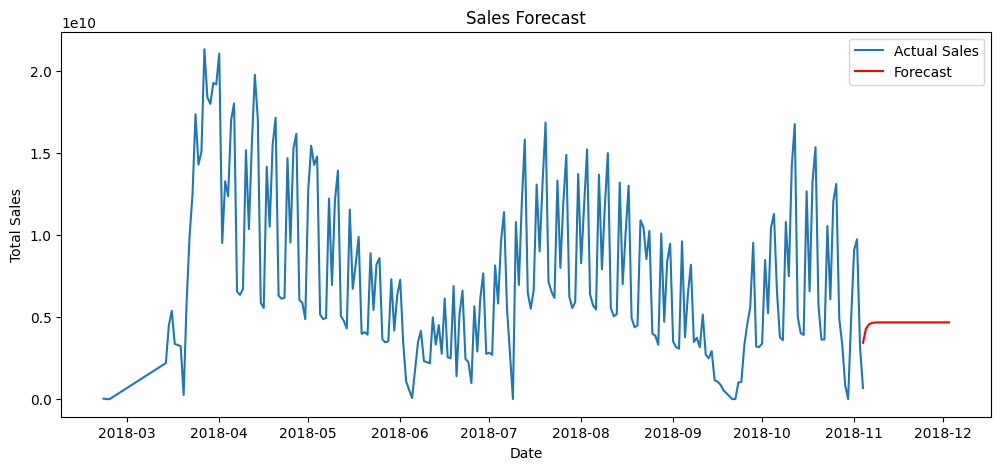

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(df_daily['total_sales'], order=(1,1,1))  # (p,d,q) values
model_fit = model.fit()

# Forecast for the next 30 days
forecast = model_fit.forecast(steps=30)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(df_daily['date'], df_daily['total_sales'], label="Actual Sales")
plt.plot(pd.date_range(df_daily['date'].iloc[-1], periods=30, freq='D'), forecast, label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Sales Forecast")
plt.legend()
plt.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/iz91npcn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/n4kr7dyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3809', 'data', 'file=/tmp/tmpr22vb2wp/iz91npcn.json', 'init=/tmp/tmpr22vb2wp/n4kr7dyh.json', 'output', 'file=/tmp/tmpr22vb2wp/prophet_model5yec_xw_/prophet_model-20250408043937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:39:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:39:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


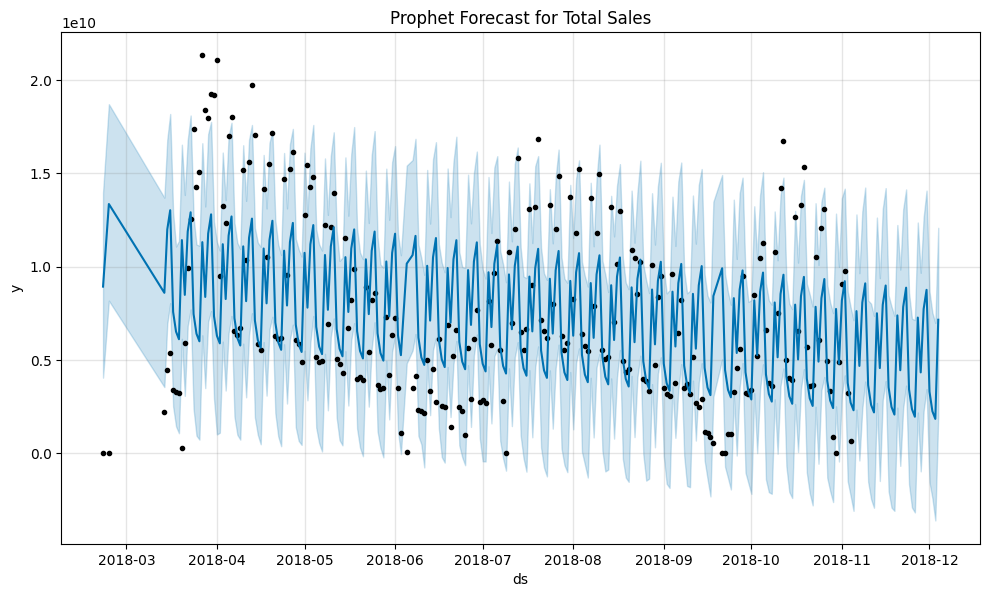

In [ ]:
from prophet import Prophet


# Prepare data for Prophet
df_prophet = df_daily[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})

# Train Prophet Model
model = Prophet()
model.fit(df_prophet)

# Make future predictions for next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot Forecast
model.plot(forecast)
plt.title("Prophet Forecast for Total Sales")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_daily['total_sales'].iloc[-30:], forecast['yhat'].iloc[-30:]))
print(f"RMSE: {rmse}")

RMSE: 6171801106.760071


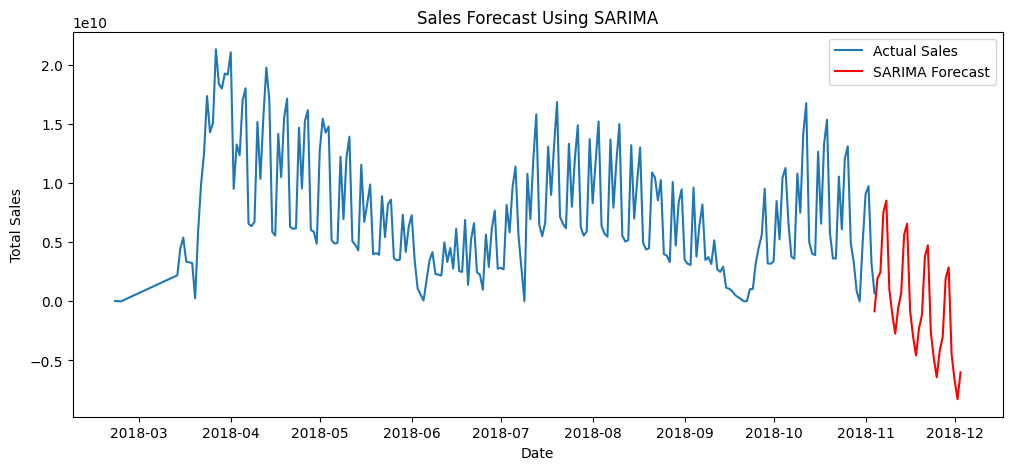

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define SARIMA model (p,d,q) x (P,D,Q,S)
sarima_model = SARIMAX(df_daily['total_sales'], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima_model.fit()

# Forecast for next 30 days
sarima_forecast = sarima_fit.forecast(steps=30)

# Plot SARIMA Forecast
plt.figure(figsize=(12, 5))
plt.plot(df_daily['date'], df_daily['total_sales'], label="Actual Sales")
plt.plot(pd.date_range(df_daily['date'].iloc[-1], periods=30, freq='D'), sarima_forecast, label="SARIMA Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Sales Forecast Using SARIMA")
plt.legend()
plt.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/e4unwv_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/44b80fri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43253', 'data', 'file=/tmp/tmpr22vb2wp/e4unwv_q.json', 'init=/tmp/tmpr22vb2wp/44b80fri.json', 'output', 'file=/tmp/tmpr22vb2wp/prophet_modelshsdaahf/prophet_model-20250408043942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:39:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:39:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


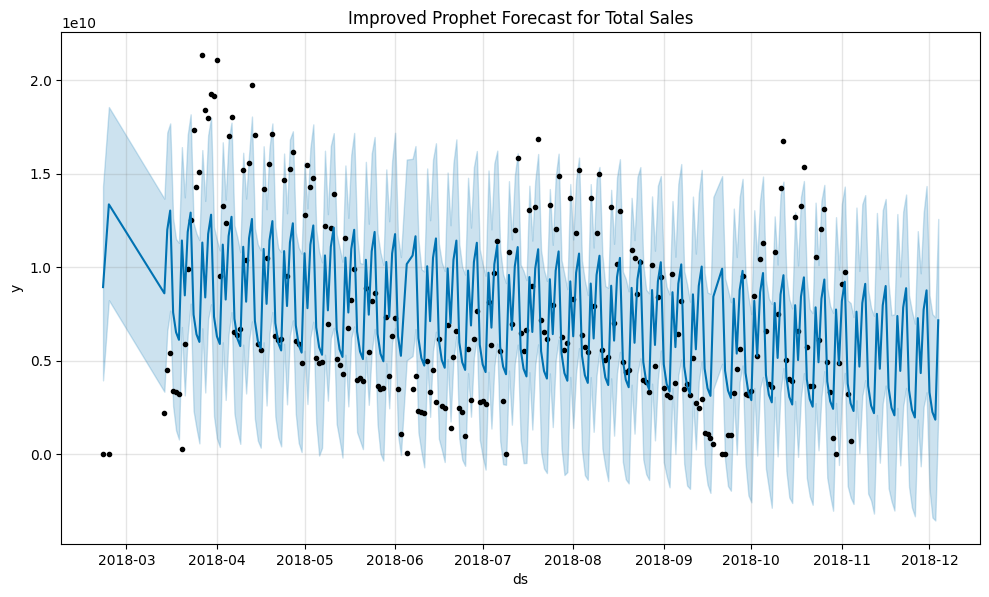

In [ ]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = df_daily[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})

# Train Prophet Model with Weekly Seasonality
model_prophet = Prophet(weekly_seasonality=True, changepoint_prior_scale=0.05)
model_prophet.fit(df_prophet)

# Make future predictions for next 30 days
future_prophet = model_prophet.make_future_dataframe(periods=30)
forecast_prophet = model_prophet.predict(future_prophet)

# Plot Prophet Forecast
model_prophet.plot(forecast_prophet)
plt.title("Improved Prophet Forecast for Total Sales")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for SARIMA
rmse_sarima = np.sqrt(mean_squared_error(df_daily['total_sales'].iloc[-30:], sarima_forecast))

# Calculate RMSE for Prophet
rmse_prophet = np.sqrt(mean_squared_error(df_daily['total_sales'].iloc[-30:], forecast_prophet['yhat'].iloc[-30:]))

print(f" SARIMA RMSE: {rmse_sarima}")
print(f" Prophet RMSE: {rmse_prophet}")

# Conclusion: Lower RMSE = Better model
if rmse_sarima < rmse_prophet:
    print(" SARIMA performed better!")
else:
    print(" Prophet performed better!")


 SARIMA RMSE: 9696224493.545048
 Prophet RMSE: 6171801106.760071
 Prophet performed better!


In [ ]:
if rmse_sarima < rmse_prophet:
    print(f" SARIMA performed better! (RMSE: {rmse_sarima:.2f})")
else:
    print(f" Prophet performed better! (RMSE: {rmse_prophet:.2f})")

 Prophet performed better! (RMSE: 6171801106.76)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/wzc6i17b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/8puxeaco.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53846', 'data', 'file=/tmp/tmpr22vb2wp/wzc6i17b.json', 'init=/tmp/tmpr22vb2wp/8puxeaco.json', 'output', 'file=/tmp/tmpr22vb2wp/prophet_modelopd0vzl3/prophet_model-20250408043944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:39:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:39:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


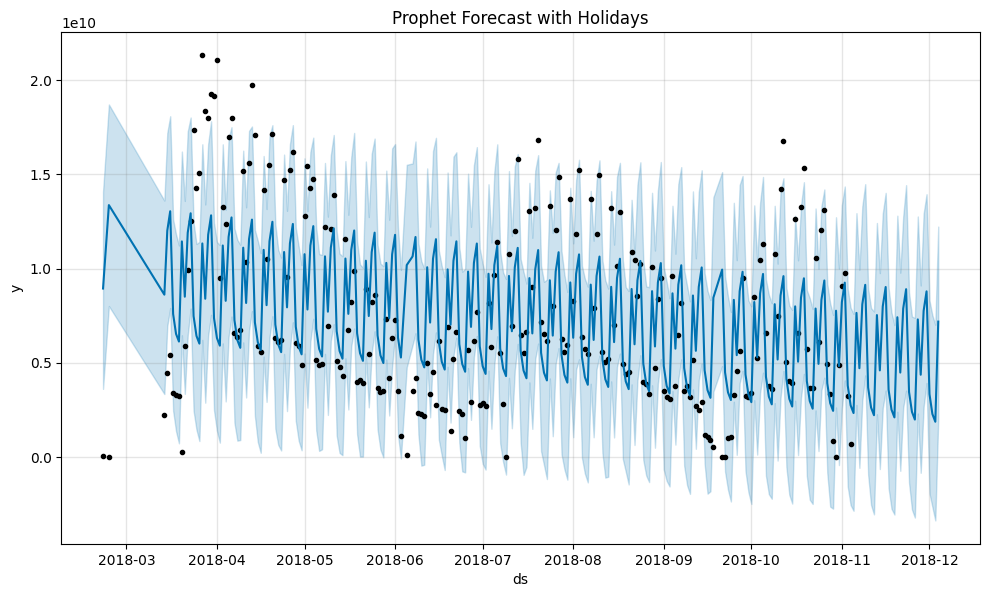

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/6d68btlu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/9qhv9v7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52278', 'data', 'file=/tmp/tmpr22vb2wp/6d68btlu.json', 'init=/tmp/tmpr22vb2wp/9qhv9v7m.json', 'output', 'file=/tmp/tmpr22vb2wp/prophet_modelq_japd91/prophet_model-20250408043946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:39:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:39:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Model saved successfully in the current directory!


In [ ]:
import joblib
# Define holiday dataframe
holidays = pd.DataFrame({
    'holiday': 'special_event',
    'ds': pd.to_datetime(['2024-01-01', '2024-07-04', '2024-12-25']),  # Example holiday dates
    'lower_window': 0,
    'upper_window': 1
})

# Train Prophet Model with Holidays
model_prophet_holidays = Prophet(weekly_seasonality=True, changepoint_prior_scale=0.05, holidays=holidays)
model_prophet_holidays.fit(df_prophet)

# Make future predictions
future_holidays = model_prophet_holidays.make_future_dataframe(periods=30)
forecast_holidays = model_prophet_holidays.predict(future_holidays)

# Plot Forecast with Holidays
model_prophet_holidays.plot(forecast_holidays)
plt.title("Prophet Forecast with Holidays")
plt.show()

# Initialize Prophet model with holidays
model_prophet_ext = Prophet(weekly_seasonality=True, changepoint_prior_scale=0.05, holidays=holidays)

# Prepare the dataset
df_prophet = df_daily[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})

# Fit the model
model_prophet_ext.fit(df_prophet)

# Make future predictions
future_ext = model_prophet_ext.make_future_dataframe(periods=30)
forecast_ext = model_prophet_ext.predict(future_ext)

# Save the trained model in the current directory
joblib.dump(model_prophet_ext, "prophet_model.pkl")
print(" Model saved successfully in the current directory!")


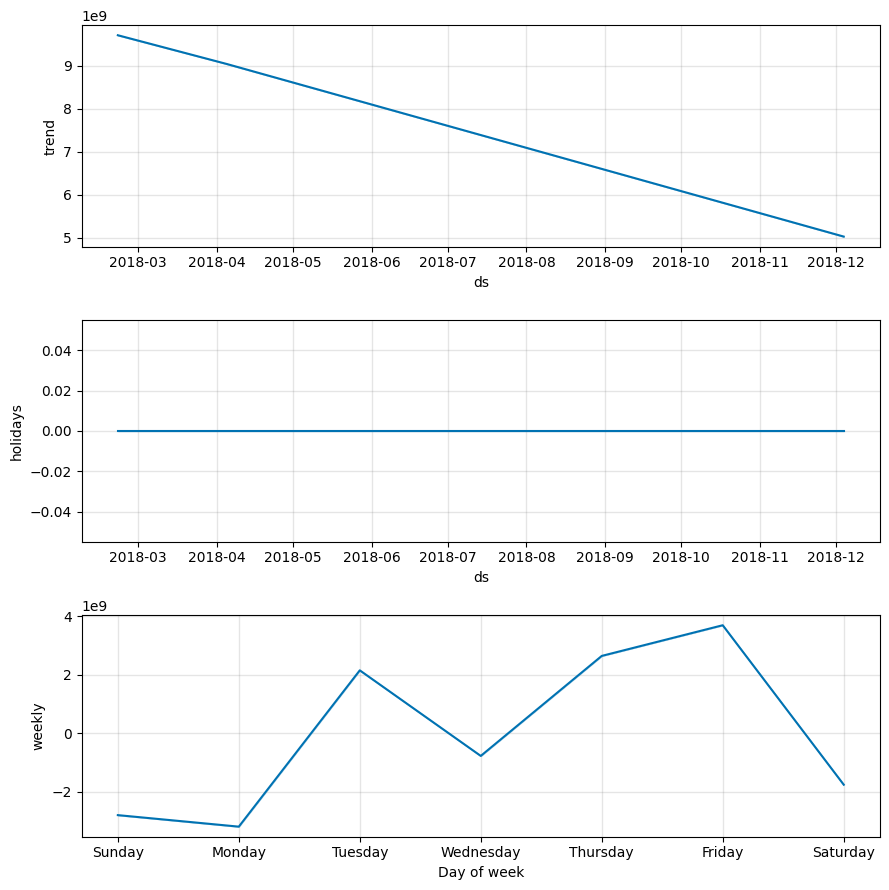

In [ ]:
model_prophet_holidays.plot_components(forecast_holidays)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Compute RMSE for Original Prophet
rmse_prophet_original = np.sqrt(mean_squared_error(df_daily['total_sales'].iloc[-30:], forecast_prophet['yhat'].iloc[-30:]))

# Compute RMSE for Prophet with Holidays
rmse_prophet_holidays = np.sqrt(mean_squared_error(df_daily['total_sales'].iloc[-30:], forecast_holidays['yhat'].iloc[-30:]))

# Print RMSE values
print(f" RMSE (Original Prophet): {rmse_prophet_original:.2f}")
print(f" RMSE (Prophet with Holidays): {rmse_prophet_holidays:.2f}")

# Check which model is better
if rmse_prophet_holidays < rmse_prophet_original:
    print("Prophet with Holidays performed better!")
else:
    print("Holidays did not improve accuracy. Try adding more events!")


 RMSE (Original Prophet): 6171801106.76
 RMSE (Prophet with Holidays): 6166040146.68
Prophet with Holidays performed better!


In [ ]:
from prophet import Prophet
import pandas as pd

# Define holiday dataframe
holidays = pd.DataFrame({
    'holiday': ['New Year', 'Independence Day', 'Christmas'],
    'ds': pd.to_datetime(['2024-01-01', '2024-07-04', '2024-12-25']),
    'lower_window': 0,
    'upper_window': 1
})

# Initialize Prophet model with holidays
model_prophet_ext = Prophet(weekly_seasonality=True, changepoint_prior_scale=0.05, holidays=holidays)

# Prepare the dataset
df_prophet = df_daily[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})

# Fit the model
model_prophet_ext.fit(df_prophet)

# Make future predictions
future_ext = model_prophet_ext.make_future_dataframe(periods=30)
forecast_ext = model_prophet_ext.predict(future_ext)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/2w9sjg8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr22vb2wp/xd3o2n8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22632', 'data', 'file=/tmp/tmpr22vb2wp/2w9sjg8y.json', 'init=/tmp/tmpr22vb2wp/xd3o2n8g.json', 'output', 'file=/tmp/tmpr22vb2wp/prophet_model_3n2ynxx/prophet_model-20250408043947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:39:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
import os

# Check if the directory exists
if not os.path.exists("/mnt/data/"):
    os.makedirs("/mnt/data/")  # Create it if missing

# Save the model
joblib.dump(model_prophet_ext, "/mnt/data/prophet_model.pkl")
print(" Model saved in /mnt/data/ successfully!")

 Model saved in /mnt/data/ successfully!
